In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

Mounted at /content/gdrive


**Dados cobertura vacinal Suíça:** [https://www.covid19.admin.ch/en/vaccination/persons/d/demography?demoSum=total](https://www.covid19.admin.ch/en/vaccination/persons/d/demography?demoSum=total)

**Dados óbitos cumulativos por sexo e faixa etárias Suíça:** [https://dc-covid.site.ined.fr/en/data/switzerland/](https://dc-covid.site.ined.fr/en/data/switzerland/)

$$ B_t = \frac{f_v(1-V_e)}{f_v(1-V_e) + (1-f_v)} $$

$$ B_t = \frac{O_{\mathrm{vax}}}{O_{\mathrm{unvax}}+O_{\mathrm{vax}}} = \frac{P f_v I_v}{P (1-f_v) I_u + P f_v I_v} = \frac{f_v I_v}{(1-f_v) I_u + f_v I_v}$$

In [2]:
def breakthrough(percent_vax, VE):
  return (percent_vax*(1-VE))/(percent_vax*(1-VE) + (1-percent_vax))

In [3]:
def frac_vac(percent_vax, inc_vac, inc_unvac):
  return inc_vac*percent_vax/(inc_unvac*(1-percent_vax) + inc_vac*percent_vax)

In [4]:
x = np.linspace(0,1,1000)

In [5]:
def rejABC(model, x, y, prior_params, eps, n_sample):
    # prior_params: list of ranges for uniform priors;
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(prior_params) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
          p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
          while p[j] > 1:
            p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
        
        d = np.sqrt(np.sum((y-model(x, p[0]))**2))/len(x)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
    
    return post[1:]

In [6]:
def sort(n, hist, bins): 
    # n: how many numbers to sort;
    # hist: l-sized array with height of columns of normalized histogram;
    # bins: (l+1)-sized array with values of bins divisions
    
    d = bins[1] - bins[0] # Bin size
    
    dat = [] # List of sorted random numbers
    
    for i in range(n):
        
        x = np.random.uniform(0., 1.)
        
        # Conversion of 0-1 random number to number sorted according to the given histogram
        for j in range(len(hist)):
            
            if (x < np.sum(hist[:j+1])*d):
                
                dat.append(np.random.uniform(bins[j], bins[j+1]))
                break
    
    return np.array(dat) # Converts list of sorted random numbers to numpy array

In [7]:
def smcABC(model, x, y, hist, bins, p_std, eps, n_sample, n_max):
    # model: function to be fit; 
    # hist+bins: past posterior for new prior
    # n_bins: number of bins to be used to make new prior from last posterior
    # p_std: standard deviations of last posterior, to add noise to new posterior
    # eps: tolerance;
    # n_sample: number of samples to be sorted
    
    n_mp = len(hist) # Number of model parameters to be fit
    
    p = np.zeros(n_mp+1, dtype=np.float64) # Array of parameters
    
    post = np.zeros((1,n_mp+1)) # Array to build posterior distribution
    
    for i in range(n_sample):
        
        # Sort parameters according to given priors
        for j in range(n_mp):
          p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j])
          while p[j] > 1:
            # p[j] = np.random.uniform(prior_params[j,0], prior_params[j,1])
            p[j] = sort(1, hist[j], bins[j]) + np.random.normal(scale=p_std[j])
        
        d = np.sqrt(np.sum((y-model(x, p[0]))**2))/len(x)
        p[-1] = d # Model-data distance
        
        # Check parameters and add sample to posterior distribution
        if (d < eps):
        
            post = np.concatenate((post, p.reshape((1,n_mp+1)))).reshape(len(post)+1, n_mp+1)
            
        if (len(post) > n_max):
            break
            
    return post[1:]

In [8]:
owid = pd.read_csv('../switzerland-covid-19-weekly-death-rate-by-vaccination-status.csv')

In [9]:
age_groups = ['50-59', '60-69', '70-79', '80+']
#Fraction vaccinated with fully vaccinated and fully vaccinated + booster
#in each age group by 25/12/2021 (two weeks before 08/01/2022)
boosted = [0.4675, 0.6127, 0.7446, 0.7555]
fully_vaxed = [0.7927, 0.8509, 0.9020, 0.9344]

In [10]:
unvac_incidences = []
fully_incidences = []
booster_incidences = []

for age_group in age_groups:
  new_df = owid.loc[owid['Entity'] == age_group].reset_index(drop=True)
  unvac_inc = new_df['Unvaccinated'][len(new_df)-1]
  fully_inc = new_df['Fully vaccinated, no booster'][len(new_df)-1]
  booster_inc = new_df['Fully vaccinated + booster'][len(new_df)-1]
  unvac_incidences.append(unvac_inc)
  fully_incidences.append(fully_inc)
  booster_incidences.append(booster_inc)

unvac_incidences = np.array(unvac_incidences)
fully_incidences = np.array(fully_incidences)
booster_incidences = np.array(booster_incidences)

In [11]:
overview = {}
overview['Metrics'] = ['Unvaxed incidence', 'Fully vaxed incidence', 'Booster incidence',
                       'Frac fully vaxed', 'Frac boosted', 'Ratio breakthrough vaxed',
                       'Vaccine effectiveness full', 'Vac eff full 2.5%', 'Vac eff full 97.5%',
                       'Ratio breakthrough boosted', 'Vaccine effectiveness boost',
                       'Vac eff boost 2.5%', 'Vac eff boost 97.5%']

prior_params = np.array([[0,1]], dtype=np.float64)
repeat = 4

for i in tqdm(range(4)):
  frac_full = frac_vac(fully_vaxed[i]-boosted[i], fully_incidences[i], unvac_incidences[i]+booster_incidences[i])
  x_full = np.array([fully_vaxed[i]-boosted[i]])
  y_full = np.array([frac_full])
  post_full = rejABC(breakthrough, x_full, y_full, prior_params, 0.2, 100000)
  for l in range(1, repeat):
    p_full = post_full[np.where(post_full[:,-1] == np.min(post_full[:,-1]))[0][0]][:-1]
    p_full_std = np.std(post_full[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    p_full_low = np.percentile(post_full[:,:-1], 2.5)
    p_full_high = np.percentile(post_full[:,:-1], 97.5)
    
    hist = np.zeros((len(p_full), 40))
    bins = np.zeros((len(p_full), 41))
    
    # Define new priors
    for k in range(len(hist)):
      hist[k], bins[k] = np.histogram(post_full[:, k], 40, density=True)
    eps = np.median(post_full[:,-1])
    post_full = smcABC(breakthrough, x_full, y_full, hist, bins, p_full_std, eps, 100000, 10000)

  frac_boost = frac_vac(boosted[i], booster_incidences[i], unvac_incidences[i]+fully_incidences[i])
  x_boosted = np.array([boosted[i]])
  y_boosted = np.array([frac_vac(boosted[i], booster_incidences[i], unvac_incidences[i])])
  post_boosted = rejABC(breakthrough, x_boosted, y_boosted, prior_params, 0.2, 100000)
  for l in range(1, repeat):
    p_boosted = post_boosted[np.where(post_boosted[:,-1] == np.min(post_boosted[:,-1]))[0][0]][:-1]
    p_boosted_std = np.std(post_boosted[:,:-1], axis=0) # Parameter error as standard deviation of posterior
    p_boosted_low = np.percentile(post_boosted[:,:-1], 2.5)
    p_boosted_high = np.percentile(post_boosted[:,:-1], 97.5)
    
    hist = np.zeros((len(p_boosted), 40))
    bins = np.zeros((len(p_boosted), 41))
    
    # Define new priors
    for k in range(len(hist)):
      hist[k], bins[k] = np.histogram(post_boosted[:, k], 40, density=True)
    eps = np.median(post_boosted[:,-1])
    post_boosted = smcABC(breakthrough, x_boosted, y_boosted, hist, bins, p_boosted_std, eps, 100000, 10000)

  overview[age_groups[i]] = [unvac_incidences[i], fully_incidences[i], booster_incidences[i],
                             fully_vaxed[i], boosted[i], frac_full, p_full[0], p_full_low, p_full_high,
                             frac_boost, p_boosted[0], p_boosted_low, p_boosted_high]

100%|██████████| 4/4 [02:41<00:00, 40.28s/it]


In [12]:
overview = pd.DataFrame(overview).set_index('Metrics')
overview

,50-59,60-69,70-79,80+
Metrics,,,,
Unvaxed incidence,0.808156,7.728214,25.589355,151.789649
Fully vaxed incidence,0.178366,0.315632,3.911292,8.881345
Booster incidence,0.000000,0.000000,0.193912,0.909965
Frac fully vaxed,0.792700,0.850900,0.902000,0.934400
Frac boosted,0.467500,0.612700,0.744600,0.755500
Ratio breakthrough vaxed,0.096138,0.012609,0.027557,0.012514
Vaccine effectiveness full,0.779296,0.959150,0.848304,0.941842
Vac eff full 2.5%,0.671025,0.761784,0.713468,0.719989
Vac eff full 97.5%,0.875419,0.988930,0.971421,0.987465


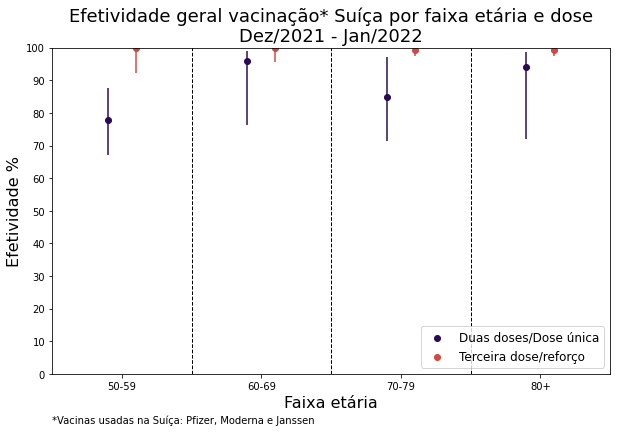

In [13]:
fig = plt.figure(figsize=(10,6))
for i in range(len(overview.columns)):
  plt.scatter(i-0.1, overview[overview.columns[i]]['Vaccine effectiveness full'],
              color = sns.color_palette('inferno')[0])
  plt.vlines(i-0.1, overview[overview.columns[i]]['Vac eff full 2.5%'],
             overview[overview.columns[i]]['Vac eff full 97.5%'],
             color = sns.color_palette('inferno')[0])
  plt.scatter(i+0.1, overview[overview.columns[i]]['Vaccine effectiveness boost'],
              color = sns.color_palette('inferno')[3])
  plt.vlines(i+0.1, overview[overview.columns[i]]['Vac eff boost 2.5%'],
             overview[overview.columns[i]]['Vac eff boost 97.5%'],
             color = sns.color_palette('inferno')[3])

plt.scatter(10, 120, color = sns.color_palette('inferno')[0], label = 'Duas doses/Dose única')
plt.scatter(10, 120, color = sns.color_palette('inferno')[3], label = 'Terceira dose/reforço')
plt.xticks([0,1,2,3], labels = age_groups)
plt.xlim(-0.5, 3.5)
plt.ylim(0, 1)
plt.title('Efetividade geral vacinação* Suíça por faixa etária e dose'
'\n'
'Dez/2021 - Jan/2022', fontsize = 18)
plt.ylabel('Efetividade %', fontsize = 16)
plt.xlabel('Faixa etária', fontsize = 16)
plt.legend(loc='lower right', fontsize = 12)
plt.vlines([0.5,1.5,2.5], 0, 1, lw = 1, linestyles = 'dashed')
plt.text(-0.5, -0.15, '*Vacinas usadas na Suíça: Pfizer, Moderna e Janssen')
plt.yticks([0.1*i for i in range(11)], labels = [10*i for i in range(11)])
fig.patch.set_alpha(1)
plt.show()

In [14]:
age_bin = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
deaths = np.array([2, 1, 4, 18, 59, 273, 852, 2402, 8360])
vacs = np.array([184,368435,715295,883916,914021,1034963,827320,667397,429375])

In [15]:
img_sw = mpimg.imread('../switzerland_icon.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


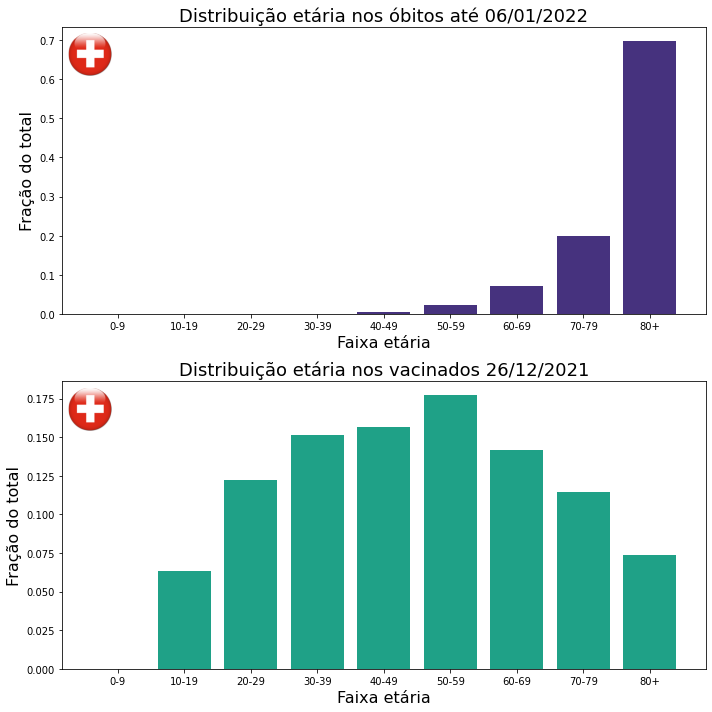

In [16]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

ax[0].bar(age_bin, deaths/np.sum(deaths), color = sns.color_palette('viridis')[0])
ax[0].set_xlabel('Faixa etária', fontsize = 16)
ax[0].set_ylabel('Fração do total', fontsize = 16)
ax[0].set_title('Distribuição etária nos óbitos até 06/01/2022', fontsize = 18)
newax = fig.add_axes([0.1,0.888,0.06,0.06], anchor='NE', zorder=1)
newax.imshow(img_sw)
newax.axis('off')

ax[1].bar(age_bin, vacs/np.sum(vacs), color = sns.color_palette('viridis')[3])
ax[1].set_xlabel('Faixa etária', fontsize = 16)
ax[1].set_ylabel('Fração do total', fontsize = 16)
ax[1].set_title('Distribuição etária nos vacinados 26/12/2021', fontsize = 18)
newax = fig.add_axes([0.1,0.395,0.06,0.06], anchor='NE', zorder=1)
newax.imshow(img_sw)
newax.axis('off')

plt.tight_layout()
fig.patch.set_alpha(1)

In [17]:
sc = pd.read_csv('../social_contact_matrix_all_locations_switzerland.csv')

In [18]:
sc = sc.set_index('Age')
sc = sc.rename(index={'75': '75+'})
sc = sc.rename(columns={'75': '75+'})

In [19]:
for i in range(len(sc)):
  for j in range(len(sc.columns)):
    sc[sc.columns[j]][i] = float(sc[sc.columns[j]][i].replace(',', '.'))

In [20]:
sc_50_59 = sc.loc[(sc.index == '50-54') | (sc.index == '55-59')]
sc_60_69 = sc.loc[(sc.index == '60-64') | (sc.index == '65-69')]

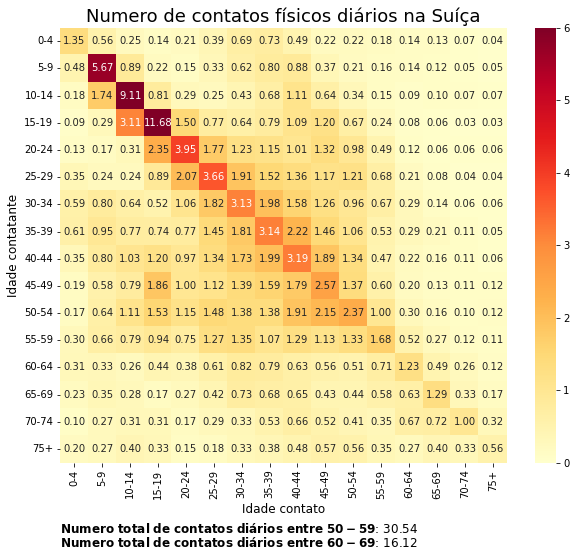

In [21]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(sc.astype('float'), cmap = 'YlOrRd', annot = True, fmt = '.2f', vmin = 0, vmax = 6)
plt.title('Numero de contatos físicos diários na Suíça', fontsize = 18)
# plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5], labels = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34',
#                       '35-39', '40-44', '45-49', '50-54', '55-59', '60-64',
#                       '65-69', '70+'])
# plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59',
#                                       '60-69', '70+'])
plt.xlabel('Idade contato', fontsize = 12)
plt.ylabel('Idade contatante', fontsize = 12)
plt.text(0, 18.6, r'$\bf{Numero}$ $\bf{total}$ $\bf{de}$ $\bf{contatos}$ $\bf{diários}$ $\bf{entre}$ $\bf{50-59}$: %.2f' %np.sum(sc_50_59.values.flatten()), fontsize = 12)
plt.text(0, 19.1, r'$\bf{Numero}$ $\bf{total}$ $\bf{de}$ $\bf{contatos}$ $\bf{diários}$ $\bf{entre}$ $\bf{60-69}$: %.2f' %np.sum(sc_60_69.values.flatten()), fontsize = 12)
fig.patch.set_alpha(1)